# Probabilistic Data Analysis


   Probabilistic data analysis -- including Bayesian inference, requires to draw samples from distributions to 

- Compute the mean and covariance of the model parameters
- Compute expectation value of a function of the model parameters
- Compute marginal distributions of the model parameters

This section will introduce different Monte Carlo methods to draw samples $\theta \in R^{N_{\theta}}$ from the posterior distribution

$$ p(\theta|y) = \frac{1}{Z} p(y|\theta) p_0(\theta) $$

where the prior distribution $p_0(\theta)$ and the likelihood function $p(y|\theta)$ can be relatively
easily computed from any particular value $(\theta, y)$, but the normalization $Z$ is diffucult to compute.

In the following, we will demonstrate 

1. random walk Metropolis-Hastings method
2. affine invariant Markov chain Monte Carlo ensemble sampler
3. Gibbs sampler
4. sequential Monte Carlo sampler 

on the 2-dimensional Rosenbrock likelihood function with prior $\mathcal{N}(0, 10^2 I)$

$$\pi(\theta_{(1)}, \theta_{(2)}) \propto \exp\Big(-\frac{100(\theta_{(2)} - \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2}{20}\Big)\frac{1}{200\pi}\exp\Big(-\frac{\theta_{(1)}^2 + \theta_{(2)}^2}{200}\Big)$$





In [8]:
function log_Rosenbrock(θ::Array{Float64,1})
    σ = 10.0
    
    θ₁, θ₂ = θ
    return (-(100(θ₂ - θ₁^2)^2 + (1 - θ₁)^2)/20) + (-(θ₁^2 + θ₂^2)/2/σ^2)
end

Rosenbrock = (θ) -> exp(log_Rosenbrock(θ));

# Random Walk Metropolis-Hastings Method


The Metropolis-Hastings method simulates samples from a probability distribution provided that we know a function $\pi(\theta)$ proportional to the density function $p(\theta)$. These samples are produced iteratively, with the distribution of the next sample being dependent only on the current sample value (thus making the sequence of samples into a Markov chain). And the transition probabilities $f(\theta'|\theta)$ is carefully designed, such that the the stationary distribution is $\pi(\theta)$ and unique:
$$\pi(\theta)f(\theta'|\theta) = \pi(\theta')f(\theta|\theta')$$

The Metropolis-Hastings method starts with a proposal distribution $q(\theta'|\theta)$, and the acceptance function $A(\theta'|\theta)$. The transition probability can be written as 

$$f(\theta'|\theta) = q(\theta'|\theta) A(\theta' | \theta)$$

The common choice of $A$, that leads to staionary distribution $\pi(\theta)$,  is the Metropolis choice

$$A(\theta'|\theta) = \min \Big(1, \frac{\pi(\theta') q(\theta|\theta')}{\pi(\theta) q(\theta'|\theta)}\Big)$$


The algorithm is 

- Propose a random candidata $\theta'$ according to $q(\theta'|\theta(t))$
- Calculate the acceptance probability $A(\theta'|\theta) = \min \Big(1, \frac{\pi(\theta') q(\theta(t)|\theta')}{\pi(\theta(t)) q(\theta'|\theta(t))}\Big)$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta(t))$, accept the proposal $\theta(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta(t))$, reject the proposal and copy the old state $\theta(t+1) =  \theta(t)$.


The random walk Metropolis-Hastings method chooses the proposal distribution $q(\theta'|\theta)$ to be

$$ q(\theta'|\theta) \sim N(\theta , \sigma^2) $$

In [27]:
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")

# compute posterior distribution by MCMC
μ0 = [0.0;0.0]
step_length = 0.1
n_ite = 10000000
us = RWMCMC_Run(log_Rosenbrock, μ0, step_length, n_ite);

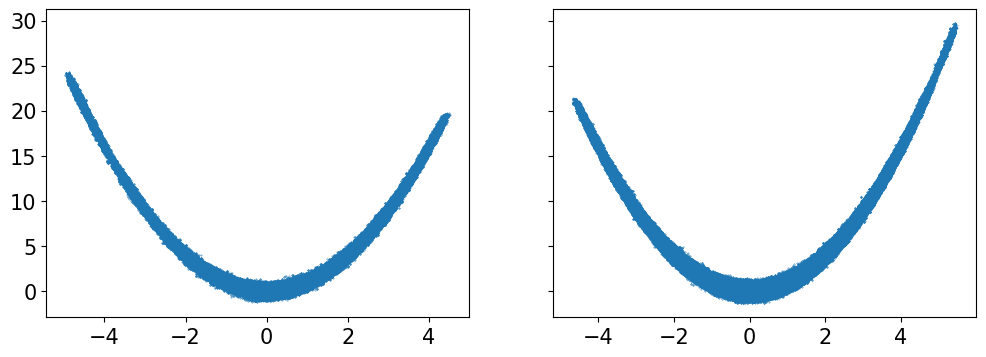

PyObject <matplotlib.collections.PathCollection object at 0x7ff2222aceb0>

In [3]:
everymarker = 1
fig, ax = PyPlot.subplots(ncols=2, sharex=false, sharey=true, figsize=(12,4))
n_burn_in, n_end = 10^5, 10^6
ax[1].scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1)
n_burn_in, n_end = 10^6, 10^7
ax[2].scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1)

# Affine Invariant Markov Chain Monte Carlo Ensemble sampler

The affine-invariant ensemble sampler for Markov chain Monte Carlo is the most popular MCMC method, since it requires fewer function calls per independent sample and is easy to parallelize.
This method involves simultaneously evolving an ensemble of $K$ walkers $S(t) = \{\theta^k(t)\}_k$
 
## Sequential Version 
 
The algorithm is sequential for $k = 1,\cdots K$
- Draw a walker $\theta^j(t)$ at random from the complementary ensemble $S_{[k]}(t)$

    $$S_{[k]}(t) = \{\theta^1(t+1),\,\cdots \theta^{k-1}(t+1),\,\theta^{k+1}(t),\,\cdots \theta^{K}(t)\}$$
    
- Generate $z \sim g(z)$, where 
$$g(z) \propto \begin{cases} \frac{1}{\sqrt{z}} & \textrm{if } z\in [\frac{1}{a}, a]\\ 0 & \textrm{otherwise}\end{cases} \qquad a = 2$$
- Propose a random candidata 
    $$\theta' = \theta^{j}(t) + z\Big[\theta^k(t) - \theta^{j}(t)\Big]$$ 
- Calculate the acceptance probability 
    $$A(\theta'|\theta^{k}) = \min \Big(1, z^{N_{\theta}-1}\frac{p(\theta')}{p(\theta^{k}(t))} \Big)$$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta^k(t))$, accept the proposal $\theta^{k}(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta^k(t))$, reject the proposal and copy the old state $\theta^{k}(t+1) =  \theta^{k}(t)$.

$z$ can be generated as $z = \frac{\Big((a-1)u + 1\Big)^2}{a}$, where $u\sim[0,1]$ is a uniform random number.


## Parallel Version 

The parallel implementation split the full ensamle into two subsets 

$$S^{(0)}(t) = \{\theta^1(t),\,\cdots \theta^{K/2}(t)\} 
\qquad S^{(1)}(t) = \{\theta^{K/2+1}(t),\,\cdots \theta^{K}(t)\}$$
    
For $i \in\{0, 1\}$

The algorithm is parallel for $k = 1,\cdots, K/2 $ or $ k = K/2+1,\cdots, K$
- Draw a walker $\theta^j(t)$ at random from the complementary ensemble $S^{(\sim i)}(t)$    
- Generate $z \sim g(z)$, where 
$$g(z) \propto \begin{cases} \frac{1}{\sqrt{z}} & \textrm{if } z\in [\frac{1}{a}, a]\\ 0 & \textrm{otherwise}\end{cases} \qquad a = 2$$
- Propose a random candidata 
    $$\theta' = \theta^{j}(t) + z\Big[\theta^k(t) - \theta^{j}(t)\Big]$$ 
- Calculate the acceptance probability 
    $$A(\theta'|\theta^{k}) = \min \Big(1, z^{N_{\theta}-1}\frac{p(\theta')}{p(\theta^{k}(t))} \Big)$$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta^k(t))$, accept the proposal $\theta^{k}(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta^k(t))$, reject the proposal and copy the old state $\theta^{k}(t+1) =  \theta^{k}(t)$.


In [34]:
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")

# compute posterior distribution by Affine invariant MCMC
μ0 = [0.0;0.0]
Σ0 = Array(Diagonal(fill(1.0^2.0, length(μ0))))

N_ens = 1000
θ0 = rand(MvNormal(μ0, Σ0), N_ens)
θ0 = Array(θ0')
n_ite = 1000
us = emcee_Run(log_Rosenbrock, θ0, n_ite);

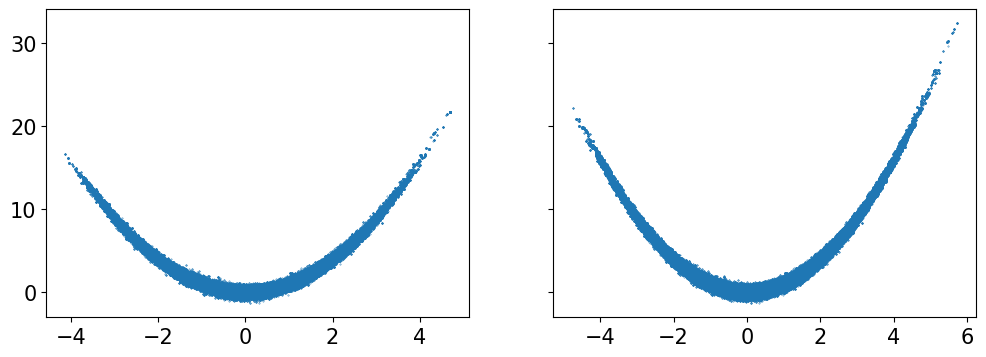

PyObject <matplotlib.collections.PathCollection object at 0x7ff2414f2160>

In [35]:
everymarker = 1
fig, ax = PyPlot.subplots(ncols=2, sharex=false, sharey=true, figsize=(12,4))
n_burn_in, n_end = 200, 500
ax[1].scatter(us[n_burn_in:everymarker:n_end, :, 1], us[n_burn_in:everymarker:n_end, :, 2], s = 0.1)
n_burn_in, n_end = 200, 1000
ax[2].scatter(us[n_burn_in:everymarker:n_end, :, 1], us[n_burn_in:everymarker:n_end, :, 2], s = 0.1)

# Gibbs Sampling

Gibbs sampling is a special Metropolis-Hastings algorithm, specifically for high-dimensional parameter vectors. 
Suppose we want to sample $\theta = (\theta_{(1)},\,\theta_{(2)},\cdots \theta_{(N_{\theta})})$ from the joint distribution $p(\theta)$, but it is easy to sample from a conditional distribution.  We can sample its components sequentially

\begin{align*}
&\theta_{(1)}(t+1) \sim p(\theta_{(1)}| \theta_{(2)}(t),\cdots \theta_{(N_{\theta})}(t)) \\
&\theta_{(2)}(t+1) \sim p(\theta_{(2)}| \theta_{(1)}(t+1), \theta_{(3)}(t),\cdots \theta_{(N_{\theta})}(t)) \\
&\qquad \vdots\\
&\theta_{(N_{\theta})}(t+1) \sim p(\theta_{(N_{\theta})}| \theta_{(1)}(t+1),\cdots \theta_{(N_{\theta}-1)}(t+1)) \\
\end{align*}

 


# Sequential Monte Carlo Sampler

Sequential Monte Carlo Sampler approximates the distibution by an ensemble of particles and the corresponding weightes.
To sample the target distribution $\mu$, sequential Monte Carlo sampler first builds a sequence of distributions $\{\mu_j\},\quad j,\cdots,\,n$, such that $\mu_1$ is easy to sample from
or to approximate and $\mu_n = \mu$, and uses MCMC kernels or approximate Gibbs steps to move the particles around
the space. The procedure is 

- Importance sampling: 
    $$\omega^k(t+1) \propto \omega^k(t) \frac{d\mu_{t+1}}{d\mu_{t}}(\theta^k(t))  \qquad \sum \omega^k(t+1) = 1 $$


- $\mu_{t+1}$-invariant update : sample $\theta(t+1)$ from $K(\mu_{t+1}, \cdot)$, where $K$ can be random walk Markov kernel

- Calculate the effective sample size (ESS)

$$ESS(t+1) = \frac{\Big(\sum \omega^j(t+1) \Big)^2}{\sum \Big(\omega^j(t+1)\Big)^2}$$

- if $ESS(t+1) \leq K$, resample  $\{\theta^j(t+1)\}$ from the present weighted distribution, and reset 
    \begin{align*} \omega^j(t+1) = \frac{1}{K}\end{align*}
    

